<ipython-input-11-33e28c8cd30d>:24: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_df.fillna(train_df.mean(), inplace=True)


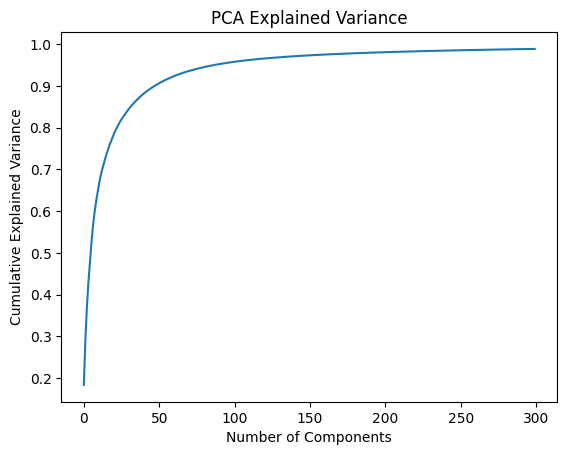

<ipython-input-11-33e28c8cd30d>:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(x_train_lda[:, 0], x_train_lda[:, 1], c=y_train_encoded, cmap=plt.cm.get_cmap('viridis', len(np.unique(y))))


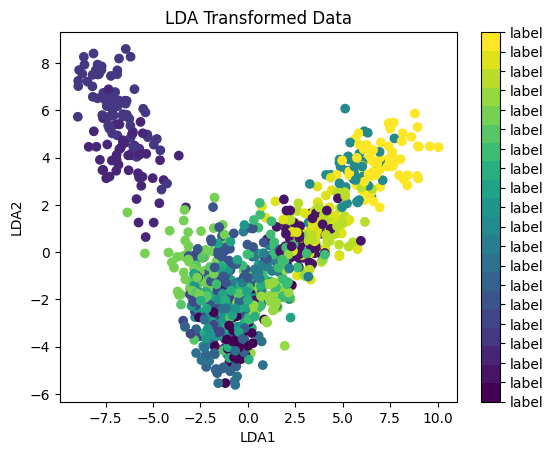

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-11-33e28c8cd30d>:80: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(x_train_lda_filtered[:, 0], x_train_lda_filtered[:, 1], c=kmeans.labels_, cmap=plt.cm.get_cmap('viridis', len(np.unique(y))))


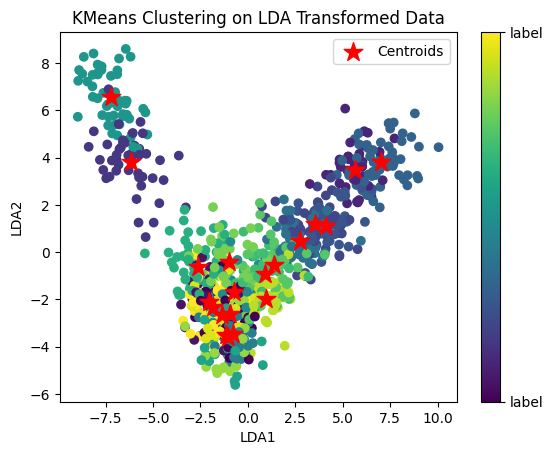

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Best parameters found for logistic regression:  {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Validation Accuracy (Logistic Regression): 0.8279


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Validation Accuracy (Ensemble): 0.8279


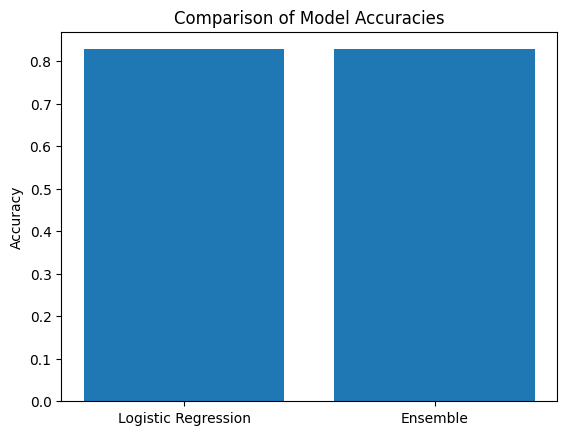

In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt

from google.colab import files

# upload = files.upload()
# upload = files.upload()

# Load the data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Preprocess the data
train_df.fillna(train_df.mean(), inplace=True)
test_df.fillna(test_df.mean(), inplace=True)

x = train_df[train_df.columns[1:-1]]
y = train_df[train_df.columns[-1]]

# Split the data into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
# Apply PCA
pca = PCA(n_components=300, random_state=42)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_val_pca = pca.transform(x_val)

# Visualize PCA explained variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.show()

# Apply LDA
lda = LinearDiscriminantAnalysis()
lda.fit(x_train_pca, y_train)
x_train_lda = lda.transform(x_train_pca)
x_val_lda = lda.transform(x_val_pca)

# Visualize the LDA transformed data
plt.figure()
plt.scatter(x_train_lda[:, 0], x_train_lda[:, 1], c=y_train_encoded, cmap=plt.cm.get_cmap('viridis', len(np.unique(y))))
plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.title('LDA Transformed Data')
plt.colorbar(ticks=range(len(np.unique(y))), format='label')
plt.show()

# Perform anomaly detection using LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
lof.fit(x_train_lda)
outlier_labels = lof.fit_predict(x_train_lda)
inliers_mask = (outlier_labels == 1)

x_train_lda_filtered = x_train_lda[inliers_mask]
y_train_filtered = y_train.values[inliers_mask]

# Perform clustering using KMeans
kmeans = KMeans(n_clusters=len(np.unique(y)), random_state=42)
kmeans.fit(x_train_lda_filtered)
x_train_clustered = kmeans.transform(x_train_lda)
x_val_clustered = kmeans.transform(x_val_lda)

# Visualize KMeans clustering on LDA transformed data
plt.figure()
plt.scatter(x_train_lda_filtered[:, 0], x_train_lda_filtered[:, 1], c=kmeans.labels_, cmap=plt.cm.get_cmap('viridis', len(np.unique(y))))
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='*', s=200, c='red', label='Centroids')
plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.title('KMeans Clustering on LDA Transformed Data')
plt.colorbar(ticks=range(len(np.unique(y))), format='label')
plt.legend()
plt.show()

# Apply Logistic Regression with GridSearchCV for hyperparameter optimization
params = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "penalty": ['l1', 'l2'],
    "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

lor = LogisticRegression(random_state=42)
grid_search = GridSearchCV(lor, param_grid=params, cv=5)
grid_search.fit(x_train_clustered, y_train)

print("Best parameters found for logistic regression: ", grid_search.best_params_)

best_lor = grid_search.best_estimator_
y_pred_val_lor = best_lor.predict(x_val_clustered)
accuracy_lor = accuracy_score(y_val, y_pred_val_lor)
print(f"Validation Accuracy (Logistic Regression): {accuracy_lor:.4f}")

# Simple ensemble with the best logistic regression model
ensemble = VotingClassifier(estimators=[('lor', best_lor)], voting='hard')
ensemble.fit(x_train_clustered, y_train)

y_pred_val_ensemble = ensemble.predict(x_val_clustered)
accuracy_ensemble = accuracy_score(y_val, y_pred_val_ensemble)
print(f"Validation Accuracy (Ensemble): {accuracy_ensemble:.4f}")

# Compare the accuracy of Logistic Regression and Ensemble models
plt.bar(['Logistic Regression', 'Ensemble'], [accuracy_lor, accuracy_ensemble])
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.show()

# Use the ensemble model for prediction
x_test = test_df[test_df.columns[1:]]
x_test_pca = pca.transform(x_test)
x_test_lda = lda.transform(x_test_pca)
x_test_clustered = kmeans.transform(x_test_lda)

y_pred_labels = ensemble.predict(x_test_clustered)
y_pred_labels_df = pd.DataFrame(y_pred_labels, columns=['category'])
y_pred_labels_df.index.name = 'ID'
y_pred_labels_df.to_csv('submission.csv', sep=',', index=True)

# files.download('submission.csv')